# ***Vit Based Approach***
Very similar to Resnet just changing the top layer and using Vision transformer instead of the Resnet and then computing vector similarity using Cosine similarity and other metrics.

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Extracting embeddings for the training dataset...


Extracting embeddings: 100%|██████████| 1875/1875 [11:39<00:00,  2.68it/s]



Evaluating system performance on 100 test samples...


Evaluating 100 samples:   1%|          | 100/10000 [00:45<1:15:29,  2.19it/s]



Average Metrics:
precision@k: 0.8100
recall@k: 0.9400
f1@k: 0.8510
accuracy: 0.8100

Visualizing an example query and its similar images...


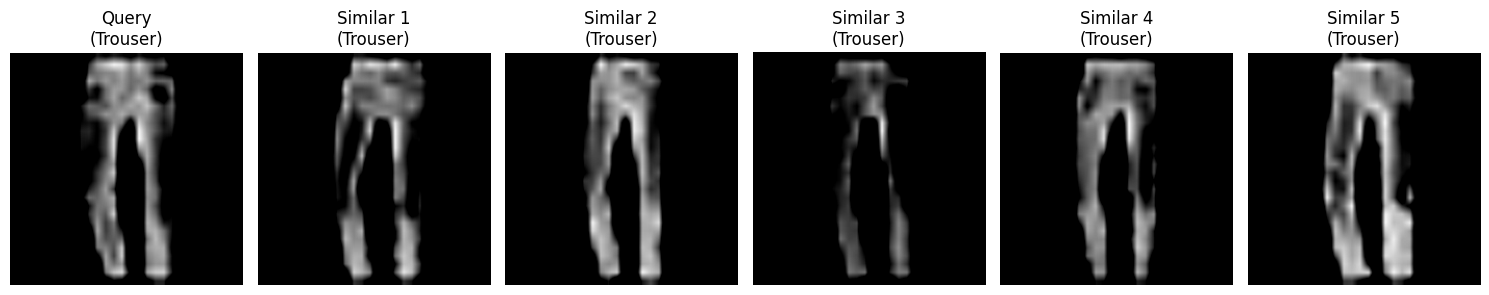

In [ ]:
import torch
import numpy as np
from torchvision import transforms, datasets
from transformers import AutoImageProcessor, AutoModel
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the Vision Transformer model and processor
model_ckpt = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def extract_embeddings(data_loader, model):
    """Extract embeddings for the entire dataset."""
    embeddings = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting embeddings"):
            images = images.to(device)
            outputs = model(images).last_hidden_state[:, 0]  # CLS token embeddings
            embeddings.append(outputs.cpu())
            labels.extend(targets.cpu().numpy())
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, labels

def compute_similarity(query_embedding, train_embeddings):
    """Compute cosine similarity between query and all training embeddings."""
    similarity_scores = torch.nn.functional.cosine_similarity(query_embedding, train_embeddings)
    return similarity_scores

def fetch_similar_images(query_image, train_embeddings, train_labels, k=5):
    """Get the k most similar images to the query image."""
    query_image = query_image.unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = model(query_image).last_hidden_state[:, 0].cpu()

    similarity_scores = compute_similarity(query_embedding, train_embeddings)
    top_k_indices = torch.topk(similarity_scores, k=k).indices.numpy()
    return top_k_indices

def evaluate_retrieval(query_label, retrieved_labels, k=5):
    """Evaluate retrieval metrics for a single query."""
    relevance = [1 if label == query_label else 0 for label in retrieved_labels]

    # Calculate Precision@k
    precision_at_k = sum(relevance) / k

    # Calculate Recall@k
    total_relevant = len([l for l in retrieved_labels if l == query_label])
    recall_at_k = sum(relevance) / total_relevant if total_relevant > 0 else 0

    # Calculate F1@k
    if precision_at_k + recall_at_k == 0:
        f1_at_k = 0
    else:
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    # Calculate accuracy
    accuracy = sum(relevance) / len(relevance)

    return {
        'precision@k': precision_at_k,
        'recall@k': recall_at_k,
        'f1@k': f1_at_k,
        'accuracy': accuracy
    }

def evaluate_system(test_loader, train_embeddings, train_labels, model, k=5, num_samples=100):
    """Evaluate the retrieval system on multiple test samples."""
    metrics_sum = {'precision@k': 0, 'recall@k': 0, 'f1@k': 0, 'accuracy': 0}
    count = 0

    for images, labels in tqdm(test_loader, desc=f"Evaluating {num_samples} samples"):
        if count >= num_samples:
            break

        query_image = images.squeeze(0)
        query_label = labels.item()

        top_k_indices = fetch_similar_images(query_image, train_embeddings, train_labels, k)
        retrieved_labels = [train_labels[idx] for idx in top_k_indices]

        sample_metrics = evaluate_retrieval(query_label, retrieved_labels, k)

        for metric in metrics_sum:
            metrics_sum[metric] += sample_metrics[metric]

        count += 1

    avg_metrics = {metric: value/count for metric, value in metrics_sum.items()}
    return avg_metrics

def visualize_results_with_labels(query_image, query_label, top_k_indices, train_dataset):
    """Visualize query image and similar images with labels and match indicators."""
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    fig, axes = plt.subplots(1, len(top_k_indices) + 1, figsize=(15, 5))

    # Show query image
    axes[0].imshow(query_image.permute(1, 2, 0).numpy())
    axes[0].set_title(f"Query\n({class_names[query_label]})")
    axes[0].axis("off")

    # Show similar images
    for i, idx in enumerate(top_k_indices):
        similar_image, label = train_dataset[idx]
        axes[i + 1].imshow(similar_image.permute(1, 2, 0).numpy())
        axes[i + 1].set_title(f"Similar {i+1}\n({class_names[label]})")
        axes[i + 1].axis("off")

        # Add green/red border based on whether the label matches
        if label == query_label:
            axes[i + 1].patch.set_edgecolor('green')
        else:
            axes[i + 1].patch.set_edgecolor('red')
        axes[i + 1].patch.set_linewidth(2)

    plt.tight_layout()
    plt.show()

def main():
    # Extract embeddings for the training dataset
    print("Extracting embeddings for the training dataset...")
    train_embeddings, train_labels = extract_embeddings(train_loader, model)

    # Evaluate system
    k = 5
    num_samples = 100
    print(f"\nEvaluating system performance on {num_samples} test samples...")
    avg_metrics = evaluate_system(test_loader, train_embeddings, train_labels, model, k, num_samples)

    print("\nAverage Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualize an example
    print("\nVisualizing an example query and its similar images...")
    query_image, query_label = next(iter(test_loader))
    query_image = query_image.squeeze(0)
    query_label = query_label.item()

    top_k_indices = fetch_similar_images(query_image, train_embeddings, train_labels, k=5)
    visualize_results_with_labels(query_image, query_label, top_k_indices, train_dataset)

if __name__ == "__main__":
    main()


Just printing results for some more queries

Extracting embeddings for the training dataset...


Extracting embeddings: 100%|██████████| 1875/1875 [11:38<00:00,  2.69it/s]



Evaluating system performance on 100 test samples...


Evaluating 100 samples:   1%|          | 100/10000 [00:42<1:10:55,  2.33it/s]



Average Metrics:
precision@k: 0.8460
recall@k: 0.9600
f1@k: 0.8810
accuracy: 0.8460

Visualizing multiple example queries and their similar images...


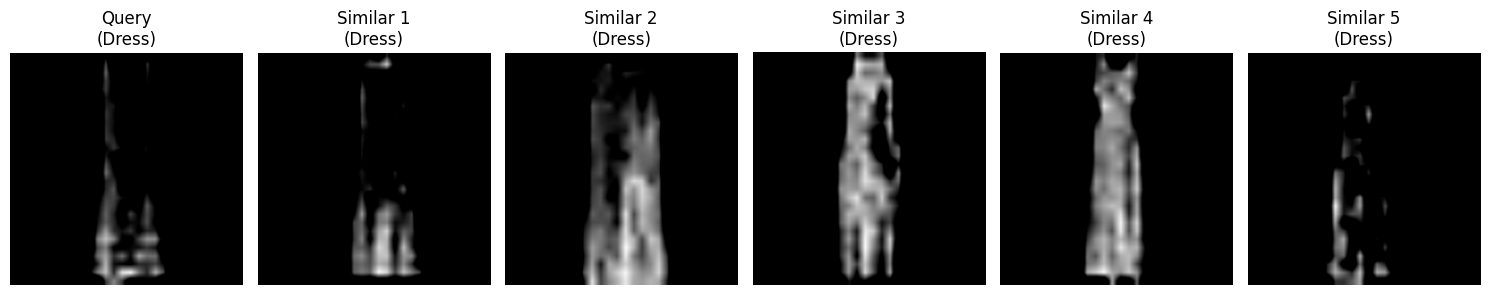

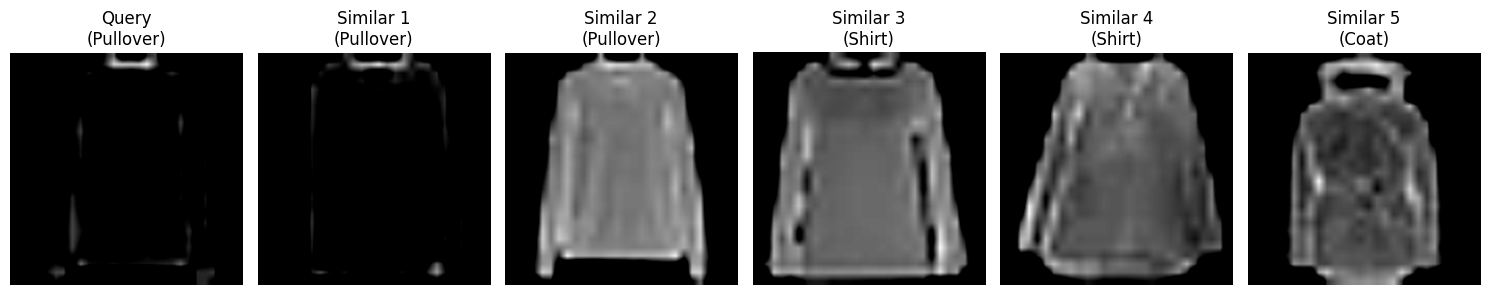

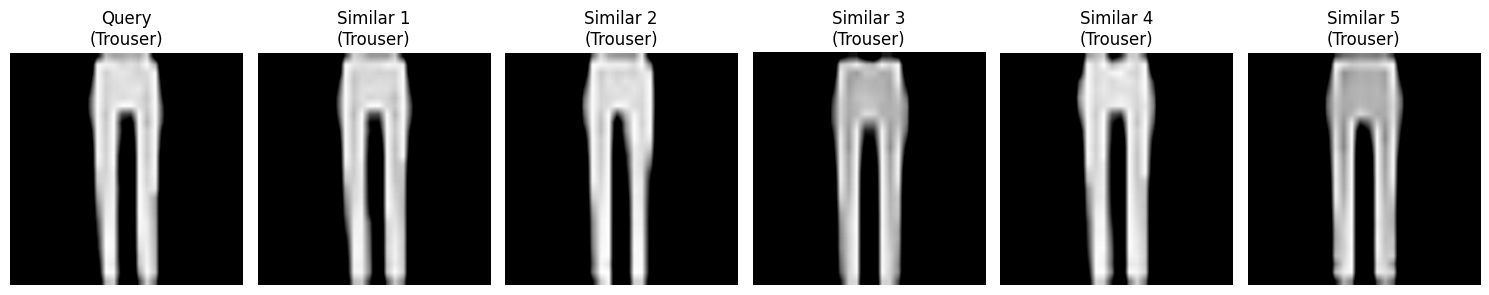

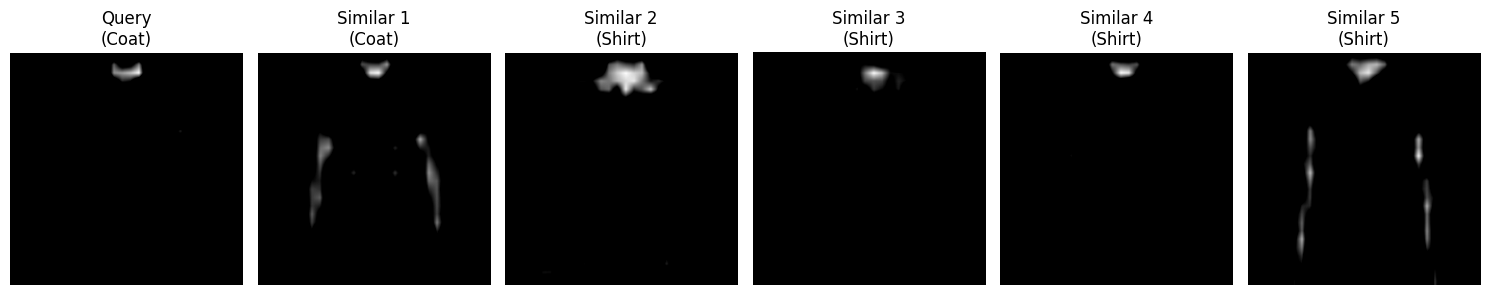

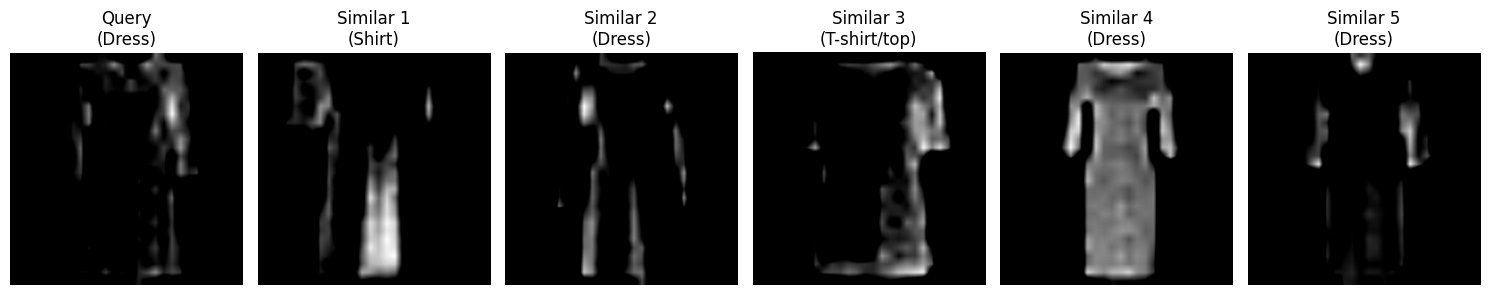

In [ ]:
def main():
    # Extract embeddings for the training dataset
    print("Extracting embeddings for the training dataset...")
    train_embeddings, train_labels = extract_embeddings(train_loader, model)

    # Evaluate system
    k = 5
    num_samples = 100
    print(f"\nEvaluating system performance on {num_samples} test samples...")
    avg_metrics = evaluate_system(test_loader, train_embeddings, train_labels, model, k, num_samples)

    print("\nAverage Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualize multiple examples
    print("\nVisualizing multiple example queries and their similar images...")
    num_visualizations = 5  # Number of examples to visualize
    count = 0

    for query_image, query_label in test_loader:
        if count >= num_visualizations:
            break

        query_image = query_image.squeeze(0)
        query_label = query_label.item()

        top_k_indices = fetch_similar_images(query_image, train_embeddings, train_labels, k=5)
        visualize_results_with_labels(query_image, query_label, top_k_indices, train_dataset)

        count += 1
if __name__ == "__main__":
    main()